# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# загрузим потенциально нужные библиотеки
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler # для масштабирования количественных признаков
from sklearn.preprocessing import OrdinalEncoder # порядковое кодирование
from sklearn.model_selection import train_test_split # деление на 2 выборки
from sklearn.model_selection import GridSearchCV # для поиска оптимальных параметров
from sklearn.metrics import mean_squared_error # для расчета MSE и RMSE
from sklearn.linear_model import LinearRegression # линейная регрессия
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time

In [2]:
# загрузим данные
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')

In [3]:
# проверим данные на всякое нехорошее. использую функцию, которой пользовался в прошлых проектах
names= [df]

def info_func(names):
    for name in names:
        df_temp = pd.DataFrame(name)
        display(df_temp.head(10))
        display(df_temp.info())
        display('Кол-во дублей:', df_temp.duplicated().sum())
        display('Кол-во НАНов:', df_temp.isna().sum())
        display('Статистика:', df_temp.describe())
    return
info_func(names)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

'Кол-во дублей:'

4

'Кол-во НАНов:'

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

'Статистика:'

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [4]:
# дубли видим, они нам не нужны
df.drop_duplicates(inplace=True)

Есть явно ненужные по своему смыслу и содержанию столбцы, их удалим. Вернуть можно в любой момент:

In [5]:
useless = ['RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures']
df = df.drop(useless, axis=1)

А вот с пропусками ситуация похуже, надо разбираться

### Заполнение пропусков

Сначала посмотрим на всё это безобразие

In [6]:
features = ['VehicleType', 'Model', 'Gearbox', 'FuelType', 'NotRepaired']
for feature in features:
    display(df[feature].value_counts(dropna=False))
    display(df[df[feature].isna()].info())

sedan          91457
small          79830
wagon          65165
NaN            37490
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37490 entries, 0 to 354365
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DateCrawled       37490 non-null  object
 1   Price             37490 non-null  int64 
 2   VehicleType       0 non-null      object
 3   RegistrationYear  37490 non-null  int64 
 4   Gearbox           27520 non-null  object
 5   Power             37490 non-null  int64 
 6   Model             30662 non-null  object
 7   Kilometer         37490 non-null  int64 
 8   FuelType          20195 non-null  object
 9   Brand             37490 non-null  object
 10  NotRepaired       16919 non-null  object
dtypes: int64(4), object(7)
memory usage: 3.4+ MB


None

golf                  29232
other                 24420
3er                   19761
NaN                   19705
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 251, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19705 entries, 1 to 354365
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DateCrawled       19705 non-null  object
 1   Price             19705 non-null  int64 
 2   VehicleType       12877 non-null  object
 3   RegistrationYear  19705 non-null  int64 
 4   Gearbox           15574 non-null  object
 5   Power             19705 non-null  int64 
 6   Model             0 non-null      object
 7   Kilometer         19705 non-null  int64 
 8   FuelType          12542 non-null  object
 9   Brand             19705 non-null  object
 10  NotRepaired       10651 non-null  object
dtypes: int64(4), object(7)
memory usage: 1.8+ MB


None

manual    268249
auto       66283
NaN        19833
Name: Gearbox, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19833 entries, 15 to 354365
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DateCrawled       19833 non-null  object
 1   Price             19833 non-null  int64 
 2   VehicleType       9863 non-null   object
 3   RegistrationYear  19833 non-null  int64 
 4   Gearbox           0 non-null      object
 5   Power             19833 non-null  int64 
 6   Model             15702 non-null  object
 7   Kilometer         19833 non-null  int64 
 8   FuelType          10913 non-null  object
 9   Brand             19833 non-null  object
 10  NotRepaired       7045 non-null   object
dtypes: int64(4), object(7)
memory usage: 1.8+ MB


None

petrol      216349
gasoline     98719
NaN          32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32895 entries, 9 to 354365
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DateCrawled       32895 non-null  object
 1   Price             32895 non-null  int64 
 2   VehicleType       15600 non-null  object
 3   RegistrationYear  32895 non-null  int64 
 4   Gearbox           23975 non-null  object
 5   Power             32895 non-null  int64 
 6   Model             25732 non-null  object
 7   Kilometer         32895 non-null  int64 
 8   FuelType          0 non-null      object
 9   Brand             32895 non-null  object
 10  NotRepaired       16314 non-null  object
dtypes: int64(4), object(7)
memory usage: 3.0+ MB


None

no     247158
NaN     71154
yes     36053
Name: NotRepaired, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71154 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DateCrawled       71154 non-null  object
 1   Price             71154 non-null  int64 
 2   VehicleType       50583 non-null  object
 3   RegistrationYear  71154 non-null  int64 
 4   Gearbox           58366 non-null  object
 5   Power             71154 non-null  int64 
 6   Model             62100 non-null  object
 7   Kilometer         71154 non-null  int64 
 8   FuelType          54573 non-null  object
 9   Brand             71154 non-null  object
 10  NotRepaired       0 non-null      object
dtypes: int64(4), object(7)
memory usage: 6.5+ MB


None

Природа пропусков в целом ясна. Либо в справочнике площадки отсуствует нужная категория, либо пользователь по какой-либо причине решил её не указывать. В любом случае, работать это будет против таких пользователей, статистика любит точность, особенно в чистоте данных. Какой то особой логики, как можно поправить пропуски достоверно, я не вижу. Перебирать 354000+ строчек в наджеде найти в строке что-то полезное, что может указать на пропущенные катеогриальные значения - тоже бессмысленно. Поэтому, предлагаю элегантное решение - заменим пропуски на other, пусть будут аутсайдерами

In [7]:
features1 = ['VehicleType', 'Model', 'Gearbox', 'FuelType']
for feature in features1:
    df[feature] = df[feature].fillna('other')

# Пропуски в столбце с ремонтами заменим на no, он там логичнее и есть вероятность, что для неремонтированных авто просто ничего не указывали
df['NotRepaired'] = df['NotRepaired'].fillna('no')

### Возможные аномалии

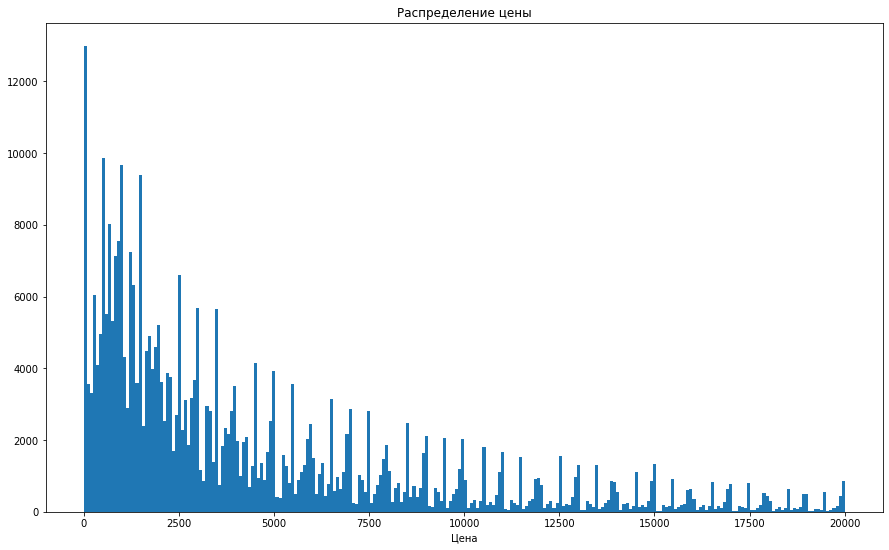

In [8]:
plt.figure(figsize=(15,9))
plt.hist(df['Price'], bins=250)
plt.title("Распределение цены")
plt.xlabel("Цена")
plt.show()

<AxesSubplot:xlabel='Price'>

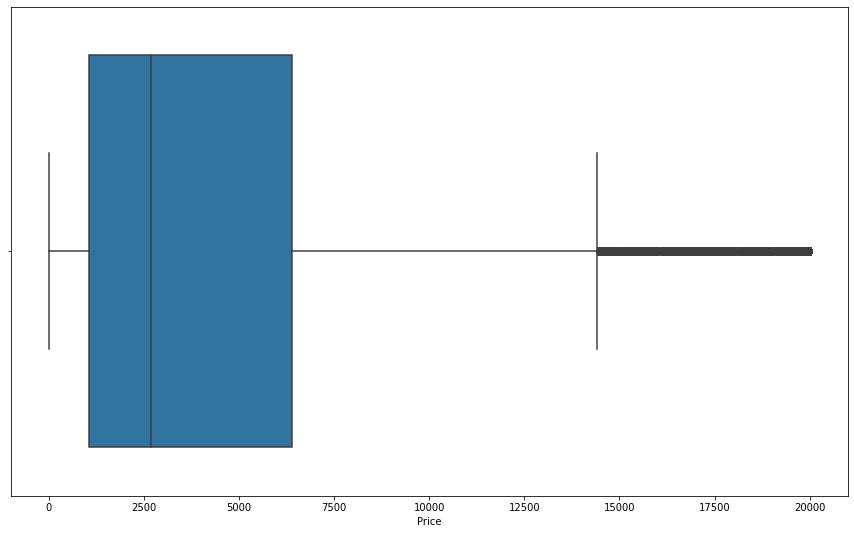

In [9]:
plt.figure(figsize=(15,9))
sns.boxplot(df['Price'])

В целом, очевидного криминала нет. В каждом ценовом диапазоне есть отчётливые пики - наверное, это и есть та самая "рыночная цена", остальные - либо торопятся, либо есть другие ньюансы. Напрягает большое количество значений в районе 0. Бесплатной машина быть не может, возможно, 0 в данном случае трактуется продавцами как катеогрия, нежели число. Здесь нужно смотреть внимательнее

In [10]:
df[df['Price'] < 100]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
40,2016-03-26 22:06:17,0,other,1990,other,0,corsa,150000,petrol,opel,no
59,2016-03-29 15:48:15,1,suv,1994,manual,286,other,150000,other,sonstige_autos,no
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no
111,2016-03-19 18:40:12,0,other,2017,manual,0,golf,5000,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...,...
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,petrol,ford,no
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,petrol,suzuki,no
354277,2016-03-10 22:55:50,0,small,1999,manual,37,arosa,150000,petrol,seat,yes
354309,2016-03-09 22:37:41,99,small,1999,manual,60,arosa,150000,petrol,seat,yes


Может тут и есть что-то стоящее, но по части информации - это хлам. Также есть вопросы к достоверности информации о ремонтах. К достоверности информации всегда есть вопросы. Предлагаю такие темы с вопросами дропнуть

In [11]:
df = df[df['Price'] != 0]
df = df.drop(df[(df['Price'] < 100) & (df['NotRepaired'] != 'no')].index).reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343036 entries, 0 to 343035
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   index             343036 non-null  int64 
 1   DateCrawled       343036 non-null  object
 2   Price             343036 non-null  int64 
 3   VehicleType       343036 non-null  object
 4   RegistrationYear  343036 non-null  int64 
 5   Gearbox           343036 non-null  object
 6   Power             343036 non-null  int64 
 7   Model             343036 non-null  object
 8   Kilometer         343036 non-null  int64 
 9   FuelType          343036 non-null  object
 10  Brand             343036 non-null  object
 11  NotRepaired       343036 non-null  object
dtypes: int64(5), object(7)
memory usage: 31.4+ MB


<AxesSubplot:xlabel='RegistrationYear'>

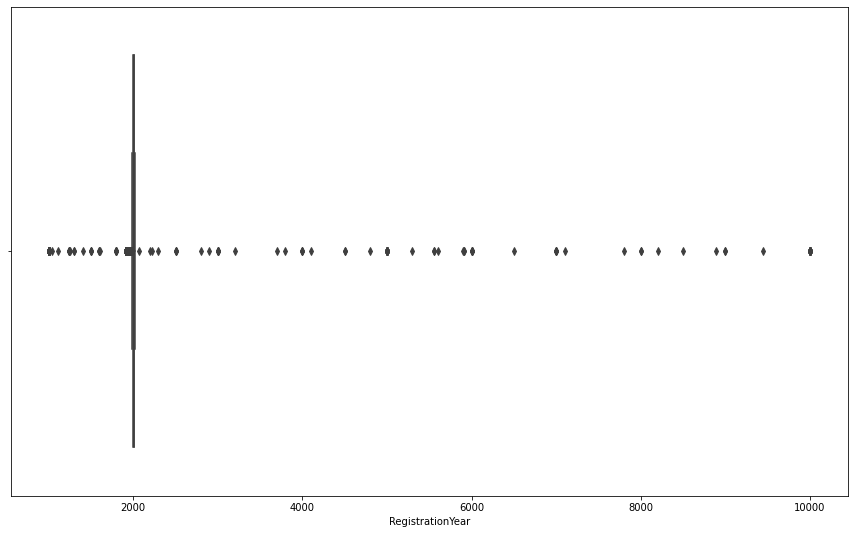

In [12]:
# также есть проблемы с годом регистрации
plt.figure(figsize=(15,9))
sns.boxplot(df['RegistrationYear'])

Есть нереальные значения, их лучше удалить. Удалять будем всё, что младше 2016 и старше 1986

In [13]:
display(df['DateCrawled'].max())
df = df.drop('DateCrawled', axis=1)

'2016-04-07 14:36:58'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314188 entries, 0 to 343035
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   index             314188 non-null  int64 
 1   Price             314188 non-null  int64 
 2   VehicleType       314188 non-null  object
 3   RegistrationYear  314188 non-null  int64 
 4   Gearbox           314188 non-null  object
 5   Power             314188 non-null  int64 
 6   Model             314188 non-null  object
 7   Kilometer         314188 non-null  int64 
 8   FuelType          314188 non-null  object
 9   Brand             314188 non-null  object
 10  NotRepaired       314188 non-null  object
dtypes: int64(5), object(6)
memory usage: 28.8+ MB


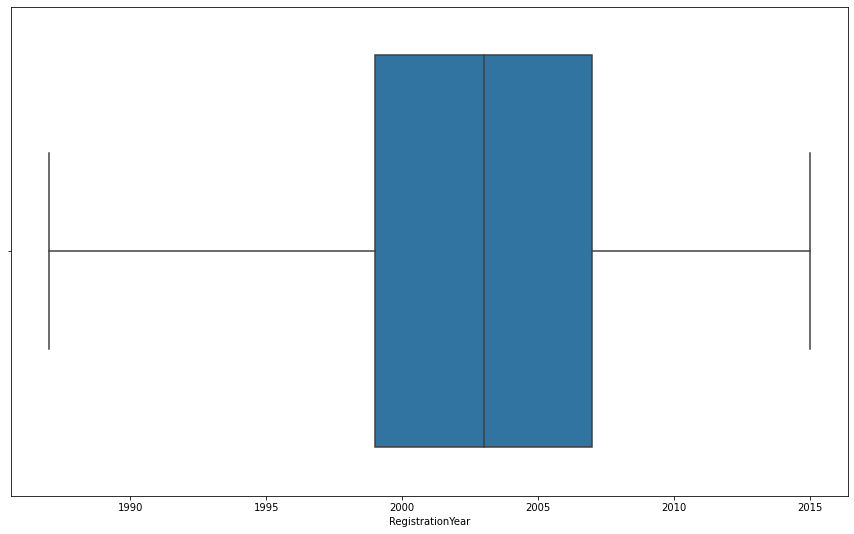

In [14]:
df = df[2016 > df['RegistrationYear']]
df = df[df['RegistrationYear'] > 1986]
plt.figure(figsize=(15,9))
sns.boxplot(df['RegistrationYear'])
df.info()

На этом, предобработку предлагаю закончить. Потеряно не так много, думаю всё будет норм

### Подготовка данных для обучения

#### Кодирование категориальных признаков

Т.к. использовать будем различные модели, то категориальные переменные необходимо для начала скодировать. Для линейной регрессии подойдет - OHE, а для деревьев и лесов - ordinal encoding, поэтому далее будет подготовлено два набора данных для обоих видов кодирования. Для бустингов - без разницы, их будем учить обычным датасетом

In [15]:
category_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
# кодирование OHE
df_ohe = pd.get_dummies(df, drop_first=True, columns=category_columns)
target_ohe = df_ohe['Price']
features_ohe = df_ohe.drop('Price', axis=1)

# кодирование OE
encoder = OrdinalEncoder()
df_oe = df.copy()
df_oe[category_columns] = encoder.fit_transform(df_oe[category_columns])
target_oe = df_oe['Price']
features_oe = df_oe.drop('Price', axis=1)

#### Разделение выборок

In [16]:
# для линейной регрессии
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
                                      features_ohe, target_ohe, test_size=0.25, random_state = 12345)
# для лесов
features_train_oe, features_test_oe, target_train_oe, target_test_oe = train_test_split(
                                      features_oe, target_oe, test_size=0.25, random_state = 12345)

#### Изменение типа данных для бустингов
Не все бустинги умеют работать с object, но это легко исправить

In [17]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

for column in categorical:
    df[column] = df[column].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314188 entries, 0 to 343035
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   index             314188 non-null  int64   
 1   Price             314188 non-null  int64   
 2   VehicleType       314188 non-null  category
 3   RegistrationYear  314188 non-null  int64   
 4   Gearbox           314188 non-null  category
 5   Power             314188 non-null  int64   
 6   Model             314188 non-null  category
 7   Kilometer         314188 non-null  int64   
 8   FuelType          314188 non-null  category
 9   Brand             314188 non-null  category
 10  NotRepaired       314188 non-null  category
dtypes: category(6), int64(5)
memory usage: 16.5 MB


In [18]:
# теперь делим
target = df['Price']
features = df.drop('Price', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
                                      features, target, test_size=0.25, random_state = 12345)

#### Масштабирование признаков

In [19]:
# для линейной регрессии
scaler = StandardScaler()

numerical = ['RegistrationYear', 'Power', 'Kilometer']

scaler.fit(features_train_ohe[numerical])

features_train_ohe[numerical] = scaler.transform(features_train_ohe[numerical])
features_test_ohe[numerical] = scaler.transform(features_test_ohe[numerical])

features_train_ohe.head()

,index,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
131177,135562,0.792286,0.195761,0.578508,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
105313,108817,0.236396,0.324865,0.578508,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
197029,203606,1.533474,0.265692,0.578508,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50877,52578,-0.690089,-0.207689,0.578508,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
211515,218614,-1.060682,-0.207689,0.578508,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [20]:
# для бустингов
scaler.fit(features_train[numerical])

features_train[numerical] = scaler.transform(features_train[numerical])
features_test[numerical] = scaler.transform(features_test[numerical])

features_train.head()

,index,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
131177,135562,sedan,0.792286,auto,0.195761,e_klasse,0.578508,gasoline,mercedes_benz,no
105313,108817,suv,0.236396,manual,0.324865,touareg,0.578508,gasoline,volkswagen,no
197029,203606,wagon,1.533474,manual,0.265692,3er,0.578508,gasoline,bmw,no
50877,52578,wagon,-0.690089,manual,-0.207689,golf,0.578508,petrol,volkswagen,no
211515,218614,small,-1.060682,manual,-0.207689,golf,0.578508,petrol,volkswagen,no


На этом предобработку и подготовку можно завершать и приступать к обучению

## Обучение моделей

Подбор параметров будет производится при помощи GridSearchCV

In [21]:
# Функция для расчёта времени обуения и предсказания
def model_best(model, X_train, y_train, X_test, y_test):
    
    start = time.time()    
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    start = time.time()  
    y_pred = model.predict(X_test)
    predict_time = time.time() - start
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return train_time, predict_time, rmse

### Линейная регрессия

In [22]:
# скорер для RMSE
def rmse_score (target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse
scorer = make_scorer(rmse_score, greater_is_better=False)

In [23]:
lr = LinearRegression()
lr_parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
lr_grid = GridSearchCV(lr, lr_parameters, cv=5, scoring=scorer, n_jobs=-1, verbose=5)
lr_grid.fit(features_train_ohe, target_train_ohe)
train_time_lr, predict_time_lr, rmse_lr = model_best(lr_grid, features_train_ohe, 
                                                                               target_train_ohe,
                                                                              features_test_ohe, 
                                                                                target_test_ohe)
print('LR:')
print('Лучшие параметры', lr_grid.best_params_)
print('Время обучения: ', round(train_time_lr, 2), 'сек')
print('Время предсказания: ', round(predict_time_lr, 2), 'сек')
print('RMSE модели: ', round(rmse_lr, 2), 'евро')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
LR:
Лучшие параметры {'fit_intercept': True, 'normalize': False}
Время обучения:  64.26 сек
Время предсказания:  0.1 сек
RMSE модели:  2462.7 евро


### Случайный лес

In [24]:
rforest = RandomForestRegressor(random_state=12345)
rforest_parameters = {'n_estimators': range(80, 101, 10),
                 'max_depth': range(10,12)}
rforest_grid = GridSearchCV(rforest, rforest_parameters,
                         cv=5, n_jobs=-1, verbose=5, scoring=scorer)
rforest_grid.fit(features_train_oe, target_train_oe)
train_time_rforest, predict_time_rforest, rmse_rforest = model_best(rforest_grid, features_train_oe, 
                                                                               target_train_oe,
                                                                              features_test_oe, 
                                                                                target_test_oe)
print('Random Forest:')
print('Лучшие параметры', rforest_grid.best_params_)
print('Время обучения: ', round(train_time_rforest, 2), 'сек')
print('Время предсказания: ', round(predict_time_rforest, 2), 'сек')
print('RMSE модели: ', round(rmse_rforest, 2), 'евро')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Random Forest:
Лучшие параметры {'max_depth': 11, 'n_estimators': 100}
Время обучения:  224.99 сек
Время предсказания:  0.62 сек
RMSE модели:  1744.85 евро


### Light GBM

In [25]:
lgbm = LGBMRegressor(random_state=12345)
lgbm_params = {'n_estimators': [300, 100, 800],
              'num_leaves': [60, 31, 91], 
              'learning_rate':[0.01, .02, 0.06]}
lgbm_grid = GridSearchCV(lgbm, lgbm_params,
                         cv=5, n_jobs=-1, verbose=5, scoring=scorer)
lgbm_grid.fit(features_train, target_train)
train_time_lgbm, predict_time_lgbm, rmse_lgbm = model_best(lgbm_grid, features_train, 
                                                                               target_train,
                                                                              features_test, 
                                                                                target_test)
print('Light GBM:')
print('Лучшие параметры', lgbm_grid.best_params_)
print('Время обучения: ', round(train_time_lgbm, 2), 'сек')
print('Время предсказания: ', round(predict_time_lgbm, 2), 'сек')
print('RMSE модели: ', round(rmse_lgbm, 2), 'евро')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Light GBM:
Лучшие параметры {'learning_rate': 0.06, 'n_estimators': 800, 'num_leaves': 91}
Время обучения:  199.69 сек
Время предсказания:  0.54 сек
RMSE модели:  1473.32 евро


### CatBoost

In [26]:
cb = CatBoostRegressor(cat_features = categorical, loss_function="RMSE")
cb_parameters = {'learning_rate': [0.03, 0.1, 0.5],
        'iterations': [150, 500]}
cb_grid = GridSearchCV(cb, cb_parameters,
                         cv=5, n_jobs=-1, verbose=5, scoring=scorer)
cb_grid.fit(features_train, target_train)
train_time_cb, predict_time_cb, rmse_cb = model_best(cb_grid, features_train, 
                                                                               target_train,
                                                                              features_test, 
                                                                                target_test)
print('CatBoost:')
print('Лучшие параметры', cb_grid.best_params_)
print('Время обучения: ', round(train_time_cb, 2), 'сек')
print('Время предсказания: ', round(predict_time_cb, 2), 'сек')
print('RMSE модели: ', round(rmse_cb, 2), 'евро')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0:	learn: 3139.3407239	total: 284ms	remaining: 2m 21s
1:	learn: 2461.6747563	total: 370ms	remaining: 1m 32s
2:	learn: 2187.0543086	total: 434ms	remaining: 1m 11s
3:	learn: 2028.0055097	total: 514ms	remaining: 1m 3s
4:	learn: 1964.3069149	total: 582ms	remaining: 57.7s
5:	learn: 1920.0225051	total: 635ms	remaining: 52.3s
6:	learn: 1874.2685005	total: 717ms	remaining: 50.5s
7:	learn: 1850.7690849	total: 806ms	remaining: 49.6s
8:	learn: 1837.4216336	total: 873ms	remaining: 47.6s
9:	learn: 1822.1182075	total: 951ms	remaining: 46.6s
10:	learn: 1808.1629181	total: 1.02s	remaining: 45.3s
11:	learn: 1795.8150917	total: 1.09s	remaining: 44.3s
12:	learn: 1785.0343032	total: 1.16s	remaining: 43.5s
13:	learn: 1775.4308967	total: 1.24s	remaining: 43s
14:	learn: 1761.4994915	total: 1.3s	remaining: 42s
15:	learn: 1754.2613815	total: 1.36s	remaining: 41.3s
16:	learn: 1743.3338242	total: 1.46s	remaining: 41.4s
17:	learn: 1736.7494490	total: 1.5

## Анализ моделей

Итого имеем:
* Light GBM имеет наилучшую оценку RMSE, но подбор параметров заняли значительно больше времени. При этом, время обучения и предсказания находятся на приемлемом уровне
* CatBoost имеет незначительно хуже оценку RMSE, подбор параметров занял сопоставимое с LGBM время. При этом, время обучения дольше LGBM в 2 раза, а время предсказания меньше в 8.
* Линейная регрессия и случайный лес имеют значительно более худшие оценки RMSE при сопаставимом быстродействии